In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import FlowCytometryTools as fct
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
batch_date = '01_21_20'
fcs_locs = "/Volumes/KeithSSD/RockCreek/RC_CellCounts/data/Pooled_Runs"
fcs_files = os.listdir(fcs_locs)
dates_tubes = [[f[:8].replace("_","-"), f[9:-4], f] for f in fcs_files if batch_date in f]
file_table = pd.DataFrame(data=dates_tubes, columns=['proc_date', 'Tube', 'fileName'])
file_table['pathName'] = file_table['fileName'].apply(lambda x: os.path.join(fcs_locs, x))
assert len(file_table['Tube'].unique()) == len(file_table['Tube'])
print("{} files detected, {} selected from {}".format(len(fcs_files), len(file_table), batch_date))
file_table.head()

193 files detected, 60 selected from 01_21_20


,proc_date,Tube,fileName,pathName
0,01-21-20,Tube_0_Beads_R1,01_21_20_Tube_0_Beads_R1.fcs,/Volumes/KeithSSD/RockCreek/RC_CellCounts/data...
1,01-21-20,Tube_0_Beads_R2,01_21_20_Tube_0_Beads_R2.fcs,/Volumes/KeithSSD/RockCreek/RC_CellCounts/data...
2,01-21-20,Tube_1,01_21_20_Tube_1.fcs,/Volumes/KeithSSD/RockCreek/RC_CellCounts/data...
3,01-21-20,Tube_2,01_21_20_Tube_2.fcs,/Volumes/KeithSSD/RockCreek/RC_CellCounts/data...
4,01-21-20,Tube_3,01_21_20_Tube_3.fcs,/Volumes/KeithSSD/RockCreek/RC_CellCounts/data...


In [3]:
def pull_relavent_metadata(x):
    meta = x.get_meta()
    _channels_ = meta['_channels_'].copy()
    voltages = _channels_[_channels_['$PnN'].str.endswith("-A")].set_index('$PnN')['$PnV'].to_dict()
    voltages = {i[:-2]+' gain':j for i, j in voltages.items()}
    voltages['startTime'] = meta['$BTIM']
    voltages['endTime'] = meta['$ETIM']
    return voltages

In [4]:
other_channels = ['Time']
measured_channels = ["FSC-A", "SSC-A", "488 530/30-A", "488 585/42-A", "488 670LP-A",
                    "488 780/60-A", "633 660/20-A", "633 780/60-A"]
b_value = 400
data_mats, meta_datas = {}, {}
for tn, pn in file_table[['Tube', 'pathName']].values:
    print("Reading {}                      ".format(tn), sep=' ', end='\r', flush=True)
    
    data_obj = fct.FCMeasurement(ID=tn, datafile=pn)
    temp_df1 = data_obj.data[measured_channels + other_channels]
    temp_df2 = temp_df1.copy()
    for ch_ in measured_channels:
        temp_df2[ch_] = data_obj.transform('hlog', channels=[ch_], b=b_value).data[ch_]
        if tn == 'Tube_10':
            min_, q1_, med_, q3_, max_ = np.percentile(temp_df1[ch_].values, [0, 25, 50, 75, 100])
            print("Pre-transform {}\t{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}".format(ch_, min_, q1_, med_, q3_, max_))
            min_, q1_, med_, q3_, max_ = np.percentile(temp_df2[ch_].values, [0, 25, 50, 75, 100])
            print("Post {}\t{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}".format(ch_, min_, q1_, med_, q3_, max_))

    data_mats[tn] = temp_df2.copy()    
    meta_datas[tn] = pull_relavent_metadata(data_obj)

Pre-transform FSC-A	-323.85	-35.70	15.30	97.75	262143.00
Post FSC-A	-1469.91	-163.67	70.17	447.55	9993.35
Pre-transform SSC-A	161.29	307.34	477.52	1242.06	262143.00
Post SSC-A	737.20	1396.27	2141.08	4488.05	9993.35
Pre-transform 488 530/30-A	-1050.29	-285.75	3491.23	33940.11	262143.00
Post 488 530/30-A	-4090.74	-1299.65	6153.25	8317.78	9993.35
Pre-transform 488 585/42-A	-107.95	1.27	25.40	81.28	128365.25
Post 488 585/42-A	-494.13	5.83	116.47	372.28	9414.88
Pre-transform 488 670LP-A	-72.39	-1.27	13.97	38.10	120694.45
Post 488 670LP-A	-331.63	-5.83	64.07	174.66	9364.75
Pre-transform 488 780/60-A	-124.46	-7.62	26.67	139.70	262143.00
Post 488 780/60-A	-569.46	-34.95	122.29	638.92	9993.35
Pre-transform 633 660/20-A	-123.50	-18.20	7.80	49.40	262143.00
Post 633 660/20-A	-565.08	-83.46	35.78	226.42	9993.35
Pre-transform 633 780/60-A	-145.60	-20.80	7.80	44.20	262143.00
Post 633 780/60-A	-665.79	-95.38	35.78	202.60	9993.35


In [5]:
file_table['proc_datetime'] = pd.to_datetime(file_table['proc_date'])
exp_cnt_file = "/Volumes/KeithSSD/RockCreek/RC_CellCounts/data/RockCreekCytometrySamples_Feb17.xlsx"
exp_cnt_df_pre = pd.read_excel(exp_cnt_file, sheet_name='Cytometry Filtered Tube Labels')
avail_dates = np.unique(exp_cnt_df_pre['Prefilter-Date'], return_counts=True)
this_date = list(file_table['proc_datetime'].unique())
assert len(this_date) == 1
print("Which of these matches most closely after {}?\n".format(this_date[0]))
print(avail_dates)
selection = int(input())
selected_date = avail_dates[0][selection]
exp_cnt_df = exp_cnt_df_pre.copy()[exp_cnt_df_pre['Prefilter-Date'] == selected_date]
print("You picked the {} records from {} <- to match -> {}".format(len(exp_cnt_df), selected_date, this_date[0]))


Which of these matches most closely after 2020-01-21T00:00:00.000000000?

(array([                          'NaT', '2019-11-26T00:00:00.000000000',
       '2019-12-04T00:00:00.000000000', '2020-01-31T00:00:00.000000000',
       '2020-02-05T00:00:00.000000000'], dtype='datetime64[ns]'), array([ 1, 33, 57, 50, 50]))
2
You picked the 57 records from 2019-12-04T00:00:00.000000000 <- to match -> 2020-01-21T00:00:00.000000000


In [6]:
exp_cnt_df['Tube_fmt'] = exp_cnt_df['Tube'].apply(lambda x: "Tube_" + str(int(x)))
exp_cnt_df[exp_cnt_df['Tube_fmt'].isin(['Tube_1', 'Tube_2', 'Tube_31'])]

,Prefilter-Date,Tube,Sample Date,Sample Time,Sample Depth,Sample Station,Notes,Processing Speed,Notes.1,Check,Tube_fmt
90,2019-12-04,2.0,2019-07-23,PM,TOP,RC7,NaN,Medium,NaN,1.0,Tube_2
91,2019-12-04,1.0,2019-07-23,PM,BOTTOM,RC7,NaN,Medium,NaN,1.0,Tube_1
168,2019-12-04,31.0,2019-07-30,AM,TOP,RC2,NaN,Medium,NaN,1.0,Tube_31


In [7]:
files_observed = sorted(list(set(file_table['Tube'])))
#files_observed.remove("")
files_observed.remove("Tube_0_Beads_R2")
files_observed.remove("Tube_0_Beads_R1")
files_observed.remove("Tube_42_Slow")
files_expected = sorted(list(set(exp_cnt_df['Tube_fmt'])))
#files_expected.remove("")
#files_expected.remove("Tube_1")
#files_expected.remove("Tube_2")
#files_expected.remove("Tube_31")

exp_cols = [ 'Sample Date', 'Sample Depth', 'Sample Time', 'Sample Station']
exp_cnt_df['data_index'] = pd.Series(index=exp_cnt_df.index)
for ix in range(max([len(files_observed), len(files_expected)])): 
    strp1, strp2 = "", ""
    if ix < len(files_observed):
        strp1 = files_observed[ix]
    if ix < len(files_expected):
        strp2 = files_expected[ix]
    print("Matched {} to {}".format(strp2, strp1))
    
    rs_1 = exp_cnt_df['Tube_fmt'] == files_expected[ix]
    ix_ex = list(exp_cnt_df.index[rs_1])[0]
    rs_2 = file_table['Tube'] == files_observed[ix]
    ix_obs = file_table.loc[rs_2, 'Tube'].values[0]
    print("\t{}".format(exp_cnt_df.loc[ix_ex, exp_cols].astype(str).values))
    assert rs_1.sum() == rs_2.sum() == 1
    exp_cnt_df.loc[ix_ex, 'data_index'] = ix_obs
    

Matched Tube_1 to Tube_1
	['2019-07-23 00:00:00' 'BOTTOM' 'PM' 'RC7']
Matched Tube_10 to Tube_10
	['2019-07-22 00:00:00' 'BOTTOM' 'PM' 'RC1']
Matched Tube_11 to Tube_11
	['2019-07-22 00:00:00' 'BOTTOM' 'AM' 'RC9']
Matched Tube_12 to Tube_12
	['2019-07-22 00:00:00' 'TOP' 'AM' 'RC7']
Matched Tube_13 to Tube_13
	['2019-07-23 00:00:00' 'TOP' 'PM' 'RC9']
Matched Tube_14 to Tube_14
	['2019-07-23 00:00:00' 'BOTTOM' 'AM' 'RC9']
Matched Tube_15 to Tube_15
	['2019-07-22 00:00:00' 'TOP' 'PM' 'RC2']
Matched Tube_16 to Tube_16
	['2019-07-22 00:00:00' 'TOP/BOTTOM?' 'AM' 'RC1']
Matched Tube_17 to Tube_17
	['2019-07-22 00:00:00' 'BOTTOM' 'AM' 'RC7']
Matched Tube_18 to Tube_18
	['2019-07-22 00:00:00' 'START BLANK' 'AM' 'nan']
Matched Tube_19 to Tube_19
	['2019-07-23 00:00:00' 'BOTTOM' 'PM' 'RC1']
Matched Tube_2 to Tube_2
	['2019-07-23 00:00:00' 'TOP' 'PM' 'RC7']
Matched Tube_20 to Tube_20
	['2019-07-22 00:00:00' 'TOP' 'PM' 'RC1']
Matched Tube_21 to Tube_21
	['2019-07-30 00:00:00' 'BOTTOM' 'PM' 'RC9']
M

In [8]:
file_table2 = file_table.set_index("Tube")

meta_df = pd.DataFrame(meta_datas).T.sort_index()

file_table3 = pd.concat((file_table2, meta_df), axis=1, sort=True, verify_integrity=True)

mad_gains = [i for i in file_table3.columns if 'gain' in i]
file_table3['all_gains'] = file_table3[mad_gains].apply(tuple, axis=1)
num_gains = file_table3['all_gains'].unique().shape[0]
print("There are {} sets of gain settings".format(num_gains))
gain_dict = {}
if num_gains > 1:
    settings_n, settings_c = np.unique(file_table3['all_gains'].values, return_counts=True)
    for setn, setc in zip(settings_n, settings_c):
        print("\t{} samples have this setting: {}".format(setc, list(zip(mad_gains, setn))))
        print("\n\t{}".format(file_table3.index[file_table3['all_gains'] == setn]))
        if setc == max(settings_c):
            gain_dict = {mg:sn for mg, sn in zip(mad_gains, setn)}
else:
    gain_dict = {mg:list(set(file_table3[mg]))[0] for mg in mad_gains}

file_table3.drop('all_gains', inplace=True, axis=1)
print(gain_dict)

There are 2 sets of gain settings
	59 samples have this setting: [('FSC gain', '325'), ('SSC gain', '525'), ('488 530/30 gain', '625'), ('488 585/42 gain', '425'), ('488 670LP gain', '425'), ('488 780/60 gain', '637'), ('633 660/20 gain', '695'), ('633 780/60 gain', '616')]

	Index(['Tube_0_Beads_R2', 'Tube_1', 'Tube_10', 'Tube_11', 'Tube_12', 'Tube_13',
       'Tube_14', 'Tube_15', 'Tube_16', 'Tube_17', 'Tube_18', 'Tube_19',
       'Tube_2', 'Tube_20', 'Tube_21', 'Tube_22', 'Tube_23', 'Tube_24',
       'Tube_25', 'Tube_26', 'Tube_27', 'Tube_28', 'Tube_29', 'Tube_3',
       'Tube_30', 'Tube_31', 'Tube_32', 'Tube_33', 'Tube_34', 'Tube_35',
       'Tube_36', 'Tube_37', 'Tube_38', 'Tube_39', 'Tube_4', 'Tube_40',
       'Tube_41', 'Tube_42', 'Tube_42_Slow', 'Tube_43', 'Tube_44', 'Tube_45',
       'Tube_46', 'Tube_47', 'Tube_48', 'Tube_49', 'Tube_5', 'Tube_50',
       'Tube_51', 'Tube_52', 'Tube_53', 'Tube_54', 'Tube_55', 'Tube_56',
       'Tube_57', 'Tube_6', 'Tube_7', 'Tube_8', 'Tube_9'],

In [9]:
file_table3

,proc_date,fileName,pathName,proc_datetime,FSC gain,SSC gain,488 530/30 gain,488 585/42 gain,488 670LP gain,488 780/60 gain,633 660/20 gain,633 780/60 gain,startTime,endTime
Tube_0_Beads_R1,01-21-20,01_21_20_Tube_0_Beads_R1.fcs,/Volumes/KeithSSD/RockCreek/RC_CellCounts/data...,2020-01-21,325,528,625,425,425,637,695,616,11:46:55,11:47:15
Tube_0_Beads_R2,01-21-20,01_21_20_Tube_0_Beads_R2.fcs,/Volumes/KeithSSD/RockCreek/RC_CellCounts/data...,2020-01-21,325,525,625,425,425,637,695,616,12:17:00,12:18:38
Tube_1,01-21-20,01_21_20_Tube_1.fcs,/Volumes/KeithSSD/RockCreek/RC_CellCounts/data...,2020-01-21,325,525,625,425,425,637,695,616,11:31:53,11:32:14
Tube_10,01-21-20,01_21_20_Tube_10.fcs,/Volumes/KeithSSD/RockCreek/RC_CellCounts/data...,2020-01-21,325,525,625,425,425,637,695,616,11:53:37,11:53:59
Tube_11,01-21-20,01_21_20_Tube_11.fcs,/Volumes/KeithSSD/RockCreek/RC_CellCounts/data...,2020-01-21,325,525,625,425,425,637,695,616,11:55:46,11:56:13
Tube_12,01-21-20,01_21_20_Tube_12.fcs,/Volumes/KeithSSD/RockCreek/RC_CellCounts/data...,2020-01-21,325,525,625,425,425,637,695,616,11:58:15,11:58:39
Tube_13,01-21-20,01_21_20_Tube_13.fcs,/Volumes/KeithSSD/RockCreek/RC_CellCounts/data...,2020-01-21,325,525,625,425,425,637,695,616,12:07:08,12:07:32
Tube_14,01-21-20,01_21_20_Tube_14.fcs,/Volumes/KeithSSD/RockCreek/RC_CellCounts/data...,2020-01-21,325,525,625,425,425,637,695,616,12:08:23,12:08:49
Tube_15,01-21-20,01_21_20_Tube_15.fcs,/Volumes/KeithSSD/RockCreek/RC_CellCounts/data...,2020-01-21,325,525,625,425,425,637,695,616,12:09:28,12:09:52
Tube_16,01-21-20,01_21_20_Tube_16.fcs,/Volumes/KeithSSD/RockCreek/RC_CellCounts/data...,2020-01-21,325,525,625,425,425,637,695,616,12:19:23,12:19:50


In [10]:
def filter_w_thresh(df, b_t, minmax, thresh):
    proc_order = list(b_t.index)
    index_sets = []
    mat_ = [df[po].values.reshape(-1,1) for po in proc_order]
    for col_i, col in enumerate(mat_):
        index_sets.append(( col >= b_t.loc[proc_order[col_i], minmax[0]] ) & ( col <= b_t.loc[proc_order[col_i], minmax[1]] ))
    
    bmat_ = np.hstack(index_sets).astype(int).sum(1)
    return list(df.index[bmat_ >= bmat_.max() - thresh])

[173163   6180]
179343 records in negative controls, 179343 used
Beads: 10182, Noise: 167465


<Figure size 432x288 with 0 Axes>

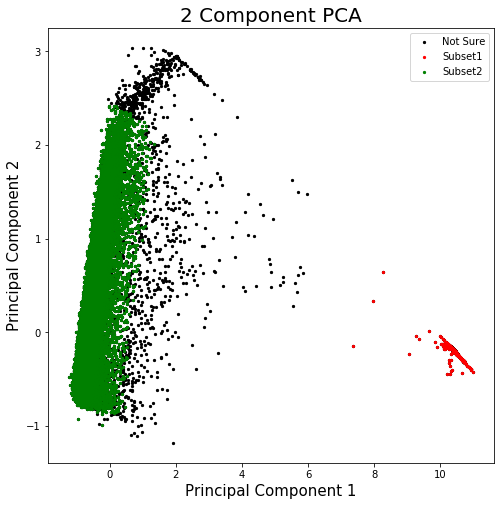

In [11]:
negative_controls = ['Tube_0_Beads_R2', 'Tube_54']
neg_ns = np.array([len(data_mats[i]) for i in negative_controls])
PC_bead_threshold = 7
print(neg_ns)
bead_df = pd.concat([data_mats[i].copy() for i in negative_controls], 
                    axis=0, ignore_index=True)
print("{} records in negative controls, {} used".format(neg_ns.sum(), bead_df.shape[0]))

real_cols = [i for i in bead_df.columns if not i in ['Time', 'FSC-A']]
x = StandardScaler().fit_transform(bead_df[real_cols].values)
pca = PCA(n_components=2, random_state=0)
jb_pca = pca.fit(x)
principalDf = pd.DataFrame(data = jb_pca.transform(x), columns = ['PC1', 'PC2'])

subset1 = list(principalDf.index[principalDf['PC1'] > PC_bead_threshold])
subset2 = list(principalDf.index[(principalDf['PC1'] <= PC_bead_threshold)]) # & (principalDf['PC2'] > -1.2)])
ss2_thres = bead_df.loc[subset2, real_cols].describe([0.00, 0.9975]).T.iloc[:, [-4,-2]]
ss2_thres.columns = ['min', 'max']
subset2 = filter_w_thresh(bead_df[real_cols].copy(), ss2_thres.loc[real_cols, :], ['min', 'max'],  0)

plt.close('all'), plt.clf()
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 Component PCA', fontsize = 20)

targets = [subset1, subset2]
labels = ['Subset1', 'Subset2']
colors = ['r', 'g']

ax.scatter(principalDf.loc[:, 'PC1'], principalDf.loc[:, 'PC2'], c='k', label='Not Sure', s = 5)

for target, color, lab in zip(targets, colors, labels):
    _ = ax.scatter(principalDf.loc[target, 'PC1'],
               principalDf.loc[target, 'PC2'], 
               c=color, label=lab, s = 5)

_ =ax.legend()
print("Beads: {}, Noise: {}".format(len(subset1), len(subset2)))

[0.94244716 0.0433118 ]
SSC-A		0.33300310373306274		0.9402572512626648
488 530/30-A		0.37542545795440674		-0.06425905227661133
488 585/42-A		0.38711944222450256		-0.15220876038074493
488 670LP-A		0.38707441091537476		-0.152692511677742
488 780/60-A		0.38696908950805664		-0.1455640345811844
633 660/20-A		0.38669300079345703		-0.1403166651725769
633 780/60-A		0.38626423478126526		-0.15629076957702637


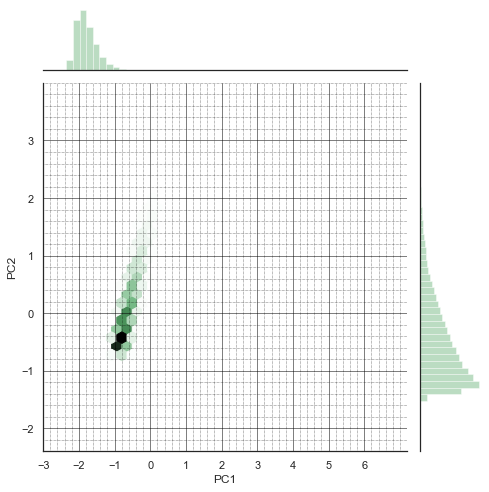

In [12]:
import seaborn as sns; 
sns.set(style="white", color_codes=True)
np.random.seed(0)

print(jb_pca.explained_variance_ratio_)
for rc_ in range(len(real_cols)):
    print("{}\t\t{}\t\t{}".format(real_cols[rc_], jb_pca.components_[0, rc_], jb_pca.components_[1, rc_]))
    
    
joint_kws_=dict(gridsize=25)
g2 = sns.jointplot("PC1", "PC2", data=principalDf.loc[set(principalDf.index) - set(subset1), :],
                   joint_kws=joint_kws_, kind="hex", color="g", height=7, zorder=0)
x_lims_ = g2.ax_joint.get_xlim()
g2.ax_joint.set_xticks(np.arange(round(x_lims_[0]-1), round(x_lims_[1]+1), 1), minor=False)
g2.ax_joint.set_xticks(np.arange(round(x_lims_[0]-1, 1), round(x_lims_[1]+1, 1), 0.2), minor=True)
y_lims_ = g2.ax_joint.get_ylim()
g2.ax_joint.set_yticks(np.arange(round(y_lims_[0]-1), round(y_lims_[1]+1), 1), minor=False)
g2.ax_joint.set_yticks(np.arange(round(y_lims_[0]-1, 1), round(y_lims_[1]+1, 1), 0.2), minor=True)
g2.ax_joint.minorticks_on()
g2.ax_joint.grid(which='major', linestyle='-', linewidth='0.5', color='black')
g2.ax_joint.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [13]:
print(len(subset1), len(subset2))
ss1_thres = bead_df.loc[subset1, real_cols].describe().T[['min', 'max']]
for rc in real_cols:
    is_ss2_gt_ss1 = ss2_thres.loc[rc, 'min'] > ss1_thres.loc[rc, 'max']
    is_ss1_gt_ss2 = ss1_thres.loc[rc, 'min'] > ss2_thres.loc[rc, 'max']
    print("{}  -- SS1 > SS2: {}, SS2 > SS1: {}".format(rc, is_ss1_gt_ss2, is_ss2_gt_ss1))
    
print(bead_df.min(0))
pd.concat((ss2_thres, ss1_thres), axis=1)

10182 167465
SSC-A  -- SS1 > SS2: False, SS2 > SS1: False
488 530/30-A  -- SS1 > SS2: True, SS2 > SS1: False
488 585/42-A  -- SS1 > SS2: True, SS2 > SS1: False
488 670LP-A  -- SS1 > SS2: True, SS2 > SS1: False
488 780/60-A  -- SS1 > SS2: True, SS2 > SS1: False
633 660/20-A  -- SS1 > SS2: True, SS2 > SS1: False
633 780/60-A  -- SS1 > SS2: False, SS2 > SS1: False
FSC-A          -1833.731812
SSC-A            360.667725
488 530/30-A   -1661.346680
488 585/42-A    -505.720032
488 670LP-A     -511.516602
488 780/60-A    -967.720337
633 660/20-A    -565.078796
633 780/60-A    -866.706299
Time              56.700001
dtype: float32


,min,max,min,max
SSC-A,360.667725,7958.871094,7708.145020,9993.349609
488 530/30-A,-1661.346680,6204.509424,9993.349609,9993.349609
488 585/42-A,-505.720032,250.268082,4637.224121,9835.110352
488 670LP-A,-511.516602,273.520538,4626.989258,9598.451172
488 780/60-A,-967.720337,1413.854810,6873.126953,9993.349609
633 660/20-A,-565.078796,701.301208,4982.075684,9993.349609
633 780/60-A,-866.706299,541.359436,321.610107,9993.349609


[  4.40941281   4.86662732   1.           7.72484509   2.79640012
   9.73782827 127.3477427 ]
1070130 records in test set, 47446 used == 2.03 samples
[0.7591899 0.1243201]
SSC-A	0.3068699836730957	0.26969823241233826
488 530/30-A	0.18536055088043213	-0.9540927410125732
488 585/42-A	0.42357897758483887	0.00503954291343689
488 670LP-A	0.424283891916275	0.08441489934921265
488 780/60-A	0.4196344017982483	0.03372979164123535
633 660/20-A	0.39872267842292786	0.0072942376136779785
633 780/60-A	0.4206709563732147	0.09288877248764038
2038
(47446, 2)
[13709, 21682, 2038]


<Figure size 432x288 with 0 Axes>

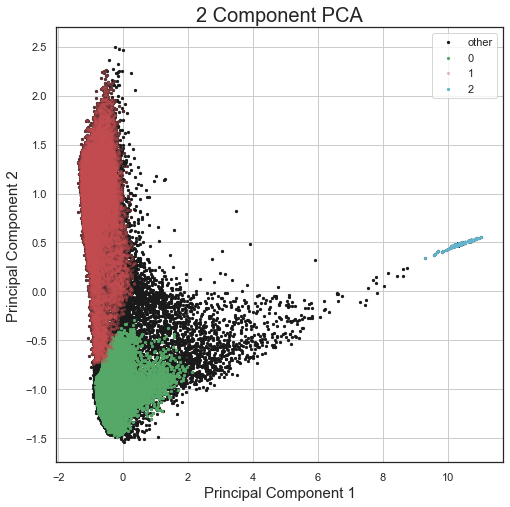

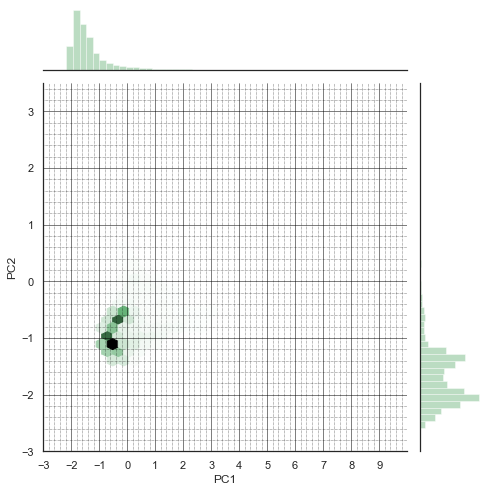

In [15]:
test_pack = ['Tube_44', 'Tube_49', 'Tube_8', 'Tube_14', 'Tube_33', 'Tube_37', 'Tube_53']
sample_size = np.array([len(data_mats[i]) for i in test_pack])
print(sample_size/sample_size.min()) 

bnc16_df = pd.concat([data_mats[i].copy().sample(sample_size.min()) for i in test_pack], 
                    axis=0, ignore_index=True)
print("{} records in test set, {} used == {:0.2f} samples".format(sample_size.sum(), bnc16_df.shape[0],
                                                                  (sample_size.min()/sample_size).sum()))
for col in ss2_thres.index:
    ss2_thres.loc[col, 'min'] = bnc16_df[col].min()

x = StandardScaler().fit_transform(bnc16_df[real_cols].values)
pca2 = PCA(n_components=2, random_state=0)
bnc_pca = pca2.fit(x)
print(bnc_pca.explained_variance_ratio_)
for rc_ in range(len(real_cols)):
    print("{}\t{}\t{}".format(real_cols[rc_], bnc_pca.components_[0, rc_], bnc_pca.components_[1, rc_]))

bnc_pc2_df = pd.DataFrame(data = bnc_pca.transform(x), columns = ['PC1', 'PC2'])

bead_events = list(bnc_pc2_df.index[bnc_pc2_df['PC1'] > 9])
print(len(bead_events))
noise_events = filter_w_thresh(bnc16_df[real_cols].copy(), ss2_thres.loc[real_cols, :], ['min', 'max'],  0)

other_events = list(set(bnc_pc2_df.index) - set(noise_events) - set(bead_events))
other_events = set(other_events).intersection(set(bnc_pc2_df.index[(bnc_pc2_df['PC2'] < -0.5) & 
                                                                   (bnc_pc2_df['PC1'] > -0.9)]))

noise_lim = bnc16_df.loc[noise_events, real_cols].describe([0.0, 1.00]).T.iloc[:, [-4,-2]]
cell_lim = bnc16_df.loc[other_events, real_cols].describe([0.05, 0.975]).T.iloc[:, [-4,-2]]
bead_lim = bnc16_df.loc[bead_events, real_cols].describe([0.00, 1.0]).T.iloc[:, [-4,-2]]

noise_lim.columns = ['Noise_min', 'Noise_max']
bead_lim.columns = ['Bead_min', 'Bead_max']
cell_lim.columns = ['Cell_min', 'Cell_max']

#blue_chan = [i for i in cell_lim.index if '488 ' in i]
#cell_lim.loc[blue_chan, 'Cell_min'] = cell_lim.loc[blue_chan, 'Cell_min']*.2
#cell_lim.loc['SSC-A', 'Cell_min'] = noise_lim.loc['SSC-A', 'Noise_min']

bead_events = filter_w_thresh(bnc16_df[real_cols].copy(), bead_lim.loc[real_cols, :], ['Bead_min', 'Bead_max'],  0)
cell_events = filter_w_thresh(bnc16_df[real_cols].copy(), cell_lim.loc[real_cols, :], ['Cell_min', 'Cell_max'],  0)
noise_events = filter_w_thresh(bnc16_df[real_cols].copy(), noise_lim.loc[real_cols, :], ['Noise_min', 'Noise_max'],  0)
print(bnc_pc2_df.shape)

targets = [cell_events, noise_events, bead_events]
print([len(i) for i in targets])
labels = ['0', '1', '2']
colors = ['g', 'r', 'c']
alphas = [1, 0.3, 1.0]

plt.close('all'), plt.clf()
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 Component PCA', fontsize = 20)
ax.scatter(bnc_pc2_df.loc[:, 'PC1'], 
           bnc_pc2_df.loc[:, 'PC2'], 
           c='k', label='other', s=5)

for target, color, lab, alpha_ in zip(targets, colors, labels, alphas):
    ax.scatter(bnc_pc2_df.loc[target, 'PC1'],
               bnc_pc2_df.loc[target, 'PC2'], 
               c=color, label=lab, s = 5, alpha=alpha_)
ax.legend()
ax.grid()

ss_mix = pd.concat((noise_lim, cell_lim, bead_lim), sort=True, axis=1)

joint_kws_=dict(gridsize=25)
gg = sns.jointplot("PC1", "PC2", data=bnc_pc2_df.loc[set(bnc_pc2_df.index) - set(bead_events) - set(noise_events), :],
                   joint_kws=joint_kws_, kind="hex", color="g", height=7, zorder=0)
x_lims_ = gg.ax_joint.get_xlim()
gg.ax_joint.set_xticks(np.arange(round(x_lims_[0]-1), round(x_lims_[1]+1), 1), minor=False)
gg.ax_joint.set_xticks(np.arange(round(x_lims_[0]-1, 1), round(x_lims_[1]+1, 1), 0.2), minor=True)
y_lims_ = gg.ax_joint.get_ylim()
gg.ax_joint.set_yticks(np.arange(round(y_lims_[0]-1), round(y_lims_[1]+1), 1), minor=False)
gg.ax_joint.set_yticks(np.arange(round(y_lims_[0]-1, 1), round(y_lims_[1]+1, 1), 0.2), minor=True)
gg.ax_joint.minorticks_on()
gg.ax_joint.grid(which='major', linestyle='-', linewidth='0.5', color='black')
gg.ax_joint.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()


In [16]:
ss_mix_2 = ss_mix.astype(int).copy()
outfile2 = os.path.join("/Volumes/KeithSSD/RockCreek/RC_CellCounts/data/Batch_Summaries", batch_date+".gains.txt")
ss_mix_2['gains'] = pd.Series({i:gain_dict[i.replace('-A', " gain")] for i in ss_mix_2.index})
ss_mix_2.to_csv(outfile2, sep="\t")
ss_mix_2
ss_mix_2.astype(int)

,Noise_min,Noise_max,Cell_min,Cell_max,Bead_min,Bead_max,gains
488 530/30-A,-4048,6203,6898,9514,9993,9993,625
488 585/42-A,-459,250,5,1588,7006,9698,425
488 670LP-A,-407,273,-93,627,7029,9643,425
488 780/60-A,-650,1413,-151,2470,8424,9993,637
633 660/20-A,-582,701,-226,6339,9993,9993,695
633 780/60-A,-736,541,-268,1411,9515,9993,616
SSC-A,673,7953,1030,6230,9699,9993,525


In [ ]:
fixative_dilution = 0.2 # mL added to the original sample 
bead_concentration = 1e6 # beads per mL
bead_volume = 0.05 # mL
cells_volume = 0.5 # mL 
ratio_multiplier = ((bead_concentration*bead_volume)/(cells_volume))/fixative_dilution

all_count_df = file_table3.copy()
new_columns = ['runtime', 'beads', 'cells', 'noise', 'concentration', 'noise_rate']
for nc in new_columns:
    all_count_df[nc] = pd.Series(index=all_count_df.index)

for tube_n, bnci_df in data_mats.items():
    beadi_events = filter_w_thresh(bnci_df.copy(), bead_lim, ['Bead_min', 'Bead_max'], 0)
    noisei_events = filter_w_thresh(bnci_df.copy(), noise_lim, ['Noise_min', 'Noise_max'], 0)
    celli_events = filter_w_thresh(bnci_df.copy(), cell_lim, ['Cell_min', 'Cell_max'], 0)

    all_count_df.loc[tube_n, ['beads', 'cells', 'noise']] = [len(beadi_events), 
                                                             len(set(celli_events) - set(beadi_events) - set(noisei_events)), 
                                                             len(noisei_events)]
    all_count_df.loc[tube_n, 'runtime'] = (bnci_df.Time.max() - bnci_df.Time.min())/100
    print(all_count_df.loc[tube_n, 'cells'])
    
# cells/bead * beads/mL = cells/mL
all_count_df['concentration'] = (all_count_df['cells'] /(all_count_df['beads']+1))*ratio_multiplier
all_count_df['noise_conc'] = (all_count_df['noise'] /(all_count_df['beads']+1))*ratio_multiplier
all_count_df['bead_rate'] = (all_count_df['beads'] /(all_count_df['runtime']+1))


In [ ]:
###### print(all_count_df[['beads', 'runtime']].describe())
fig5, ax5 = plt.subplots(nrows=1, ncols=1, figsize=(6,6), num=5, dpi=100)
ax5.scatter(all_count_df['concentration'].values, all_count_df['runtime'], marker='o')
ax5.set(ylabel='runtime', xlabel='concentration', xlim=(-100, 5e7));
plt.tight_layout()

fig6, ax6 = plt.subplots(nrows=1, ncols=1, figsize=(6,6), num=6, dpi=100)
ax6.hist(all_count_df.loc[all_count_df['bead_rate'].notnull() , 'bead_rate'])
ax6.set_title('bead rate')
plt.tight_layout()
plt.show()

clean_counts = all_count_df.copy()[(all_count_df['beads'] > 800) & (all_count_df['bead_rate'] > 5)]
print(clean_counts.shape, all_count_df.shape)
all_count_df.loc[( (all_count_df['bead_rate'] < 7) | (all_count_df['beads'] < 800) | (all_count_df['beads'] > 1100)) | (all_count_df['runtime'] < 15) , :]

In [ ]:
check_sample2 = pd.concat([data_mats[i] for i in ['Tube_30', 'Tube_27', 'Tube_25']], ignore_index=True)

pca2 = PCA(n_components=2, random_state=0)
x = StandardScaler().fit_transform(check_sample2[real_cols].values)
cs_pca = pca2.fit(x)
cs_pc2_df = pd.DataFrame(data = cs_pca.transform(x), columns = ['PC1', 'PC2'])

bead_cs_v2 = filter_w_thresh(check_sample2.copy(), bead_lim, ['Bead_min', 'Bead_max'], 0)
noise_cs_v2 = filter_w_thresh(check_sample2.copy(), noise_lim, ['Noise_min', 'Noise_max'], 0) 
cells_cs_v2 = filter_w_thresh(check_sample2.copy(), cell_lim, ['Cell_min', 'Cell_max'], 0)
cells_cs_v2 = list(set(cells_cs_v2) - set(noise_cs_v2))

assert len(set(bead_cs_v2).intersection(set(noise_cs_v2))) == 0
assert len(set(noise_cs_v2).intersection(set(cells_cs_v2))) == 0
assert len(set(bead_cs_v2).intersection(set(cells_cs_v2))) == 0

targets = [bead_cs_v2, noise_cs_v2, cells_cs_v2]
print([len(i) for i in targets])
print(len(cs_pc2_df))
labels = ['Beads', 'Noise', 'Cells']
colors = ['g', 'r', 'c']
alphas = [1, 0.3, 1.0]

plt.close('all'), plt.clf()
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('Low Bead Count Sample PCA', fontsize = 15)
xtpytp = cs_pc2_df[['PC1', 'PC2']].sample(50000)
ax.scatter(xtpytp['PC1'], xtpytp['PC2'], c='k', label='other', s=5)

for target, color, lab, alpha_ in zip(targets, colors, labels, alphas):
    subtarg = set(target).intersection(set(xtpytp.index))
    ax.scatter(xtpytp.loc[subtarg, 'PC1'],
               xtpytp.loc[subtarg, 'PC2'], 
               c=color, label=lab, s = 5, alpha=alpha_)
ax.legend()
plt.show()
print((cs_pc2_df['PC1'] > 12.5).sum())

In [ ]:
clean_counts['log-noise'] = clean_counts['noise_conc'].apply(lambda x: np.log10(x) if x > 0 else 0)
clean_counts['log-conc'] = clean_counts['concentration'].apply(lambda x: np.log10(x) if x > 0 else 0)

for nc in ['log-conc','log-noise', 'concentration', 'proc_datetime']:
    exp_cnt_df[nc] = pd.Series(index=exp_cnt_df.index)    
    for ix in exp_cnt_df.index[exp_cnt_df['data_index'].notnull()]:
        cc_ix = exp_cnt_df.loc[ix, 'data_index']
        if cc_ix in list(clean_counts.index):
            exp_cnt_df.loc[ix, nc] = clean_counts.loc[cc_ix, nc]
        
# plot log-exp (x) against log-conc (y)
# sybr gets green, pi gets red
# f / uf pairs get numbers 
exp_cnt_df_plt = exp_cnt_df.copy()[exp_cnt_df[['log-conc', 'log-noise']].isnull().sum(1) == 0]
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4,4), num=1, dpi=100)
ax.scatter(exp_cnt_df_plt['log-conc'], exp_cnt_df_plt['log-noise'], s=160, c='k', marker='.')
ax.set(ylabel='Noise Event Density (log10)', xlabel='Observed Counts (log10)');
plt.show()

clean_counts['conc_int'] = clean_counts['concentration'].astype(int)
exp_cnt_df_plt['conc_int'] = exp_cnt_df_plt['concentration'].astype(int)
exp_cnt_df_plt.loc[:, ['data_index'] + exp_cols + ['conc_int', 'log-noise']].sort_values(by='conc_int')


In [ ]:
outfile = os.path.join("/Volumes/KeithSSD/RockCreek/RC_CellCounts/data/Batch_Summaries", batch_date+".txt")
exp_cnt_df_plt.to_csv(outfile, sep="\t", index=False)
print(exp_cnt_df_plt.shape)
print(exp_cnt_df_plt.columns)

In [ ]:
exp_cnt_df_plt